# Results of human-LLM collaboration

Example notebook for the BrainGPT project

## Load libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import statsmodels.api as sm
import statsmodels.tools as sm_tools

## Add labels to data

In [2]:
# Set path to directories
root_path, results_path = '../data/', '../results/'

# Load the results for all team member combinations on GPT-4 generated abstracts
logistic_results = pd.read_csv(f"{results_path}Logistic_predictions.csv")

# Set labels for the type of team
lab_single, lab_HM = 'Human or LLM only', 'Human-LLM'

# Set type of team
llms = list(logistic_results.iloc[:,1:-1].columns)
df = logistic_results.copy()
df['Classifier'] = df.iloc[:,1:-1].apply(lambda x: 'Human' if not x[llms].any() else '-'.join([col for col in llms if x[col]]), axis=1)
df['Type'] = df.iloc[:,:-2].apply(lambda x: lab_single if not x['Human'] else lab_HM if x.sum() > 1 else lab_single, axis=1)
df['Accuracy'] = df['Accuracy'] * 100

# Get number of observations
online_study = pd.read_csv(f"{root_path}human/data/participant_data.csv")
abstract_idx = online_study['journal_section'].str.startswith('machine')
n = online_study[abstract_idx].shape[0]

# Calculate error bars (sem binomial data) for each point
df['SE'] = df.apply(lambda x: np.sqrt(x['Accuracy'] * (100 - x['Accuracy']) / n), axis=1)

df

,Human,7B,13B,70B,Accuracy,Classifier,Type,SE
0,True,False,False,False,69.781312,Human,Human or LLM only,2.047497
1,False,True,False,False,72.564612,7B,Human or LLM only,1.989454
2,False,False,True,False,72.564612,13B,Human or LLM only,1.989454
3,False,False,False,True,74.552684,70B,Human or LLM only,1.942087
4,True,True,False,False,78.528827,7B,Human-LLM,1.830874
5,True,False,True,False,80.318091,13B,Human-LLM,1.772786
6,True,False,False,True,79.522863,70B,Human-LLM,1.799271
7,False,True,True,False,76.540755,7B-13B,Human or LLM only,1.889380
8,False,True,False,True,74.155070,7B-70B,Human or LLM only,1.951974
9,False,False,True,True,75.546720,13B-70B,Human or LLM only,1.916427


## Figure 3

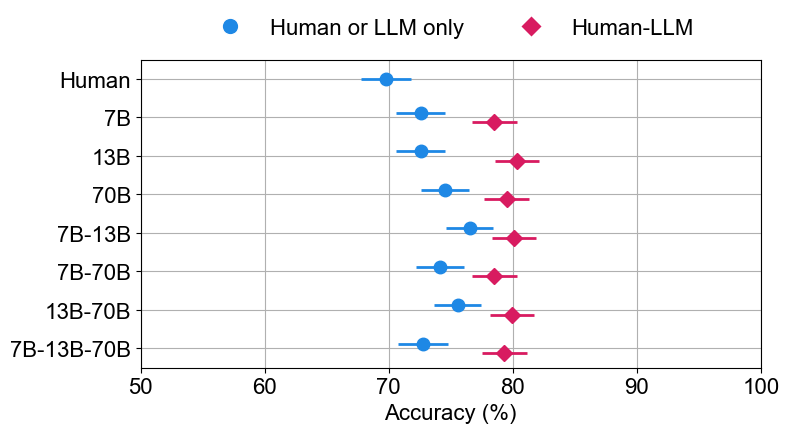

In [3]:
# Set the style and font using matplotlib
plt.rc('font', family='Arial')
plt.rc('axes', grid=True)
plt.rc('axes', facecolor='white')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 4))

# Define custom colors for each type
mycolors  = {lab_single: '#1E88E5', lab_HM: '#D81B60'}
mymarkers = {lab_single: 'o',       lab_HM: 'D'}
mymarksze = {lab_single: 9,         lab_HM: 8}

# Font size
fs = 16

# Define the width of the dodge
dodge_width = 0.125

# Create a list of classifiers per type
n_classifiers = np.arange(0, len(df['Classifier'].unique()))

# Create error bars
for i, type in enumerate(df['Type'].unique()):
    type_data = df[df['Type'] == type]
    y_coords = n_classifiers[i:] + (i-0.5)*2*dodge_width*(n_classifiers[i:]>0)
    ax.errorbar(type_data['Accuracy'], y_coords, xerr=type_data['SE'], \
        fmt=mymarkers[type], markersize=mymarksze[type], capsize=0, color=mycolors[type], \
            elinewidth=2, label=type)

# Set x-axis limits
ax.set_xlim([50, 100])
ax.set_xticks([50, 60, 70, 80, 90, 100])
ax.set_xlabel("Accuracy (%)", fontsize=fs)  # Rename the x-axis label

# Reverse the y-axis
ax.set_yticks(n_classifiers, df['Classifier'].unique())
ax.set_ylim([-0.5, 7.5])
ax.invert_yaxis()

# Increase the size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=fs)

# Show the legend
legend_elements = [Line2D([0], [0], marker=mymarkers[type], color='w', label=type, \
    markerfacecolor=mycolors[type], markersize=3+mymarksze[type], linestyle='None') \
        for type in df['Type'].unique()]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.2), \
    ncol=len(df['Type'].unique()), frameon=False, fontsize=fs)

# Show the plot
plt.show()

## Table 1

In [4]:
# Create the design matrix and target with all combinaitons 
X, y = logistic_results.iloc[:,:-1].astype(float), logistic_results['Accuracy'].values
X = sm_tools.add_constant(X)

In [5]:
# Set collaboration with one machine
N = np.sum(X.iloc[:,2:].sum(axis=1) <= 1)
X1, y1 = X.iloc[:N,:], y[:N]

# Fit the model
lr = sm.OLS(y1, X1).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     24.47
Date:                Sat, 10 Aug 2024   Prob (F-statistic):             0.0397
Time:                        15:56:20   Log-Likelihood:                 26.707
No. Observations:                   7   AIC:                            -43.41
Df Residuals:                       2   BIC:                            -43.68
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6355      0.013     49.358      0.0

C:\Users\yanez\AppData\Roaming\Python\Python311\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


## Table 2

In [6]:
# Set collaboration with up to two machines
N = np.sum(X.iloc[:,2:].sum(axis=1) <= 2)
X1, y1 = X.iloc[:N,:], y[:N]

# Fit the model
lr = sm.OLS(y1, X1).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     4.660
Date:                Sat, 10 Aug 2024   Prob (F-statistic):             0.0309
Time:                        15:56:21   Log-Likelihood:                 33.663
No. Observations:                  13   AIC:                            -57.33
Df Residuals:                       8   BIC:                            -54.50
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6949      0.018     38.023      0.0

c:\Users\yanez\Miniconda3\envs\brainGPT_env\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## Figure 4

In [ ]:
# Load the results for human-LLM teams with the Bayesian Combination Model
b07 = pd.read_csv(f"{results_path}Bayesian_HM_predictions_7B.csv").mean() * 100
b13 = pd.read_csv(f"{results_path}Bayesian_HM_predictions_13B.csv").mean() * 100
b70 = pd.read_csv(f"{results_path}Bayesian_HM_predictions_70B.csv").mean() * 100

# Create a dataframe with the results
df2 = pd.DataFrame({'Accuracy': [b07['AB'], b13['AB'], b70['AB']], 
                    'Classifier': ['7B', '13B', '70B'], 
                    'Type': 'Bayesian'})

# Calculate error bars (sem binomial data) for each point
df2['SE'] = df2.apply(lambda x: np.sqrt(x['Accuracy'] * (100 - x['Accuracy']) / n), axis=1)

# Add results for the logistic model
df2 = pd.concat([df2, df.loc[(df['Type'] == lab_HM) & (df['Classifier'].isin(df2['Classifier'])), df2.columns]])
df2['Type'] = df2['Type'].replace(lab_HM, 'Logistic')

# Update classifier names
df2['Classifier'] = 'Human-' + df2['Classifier']

df2

In [ ]:
# Set the style and font using matplotlib
plt.rc('font', family='Arial')
plt.rc('axes', grid=True)
plt.rc('axes', facecolor='white')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 2))

# Define custom colors for each type
mycolors  = {'Bayesian': '#158E6B', 'Logistic': '#D81B60'}
mymarkers = {'Bayesian': 'o',       'Logistic': 'D'}
mymarksze = {'Bayesian': 9,         'Logistic': 8}

# Font size
fs = 16

# Define the width of the dodge
dodge_width = 0.125

n_classifiers = np.arange(0, len(df2['Classifier'].unique()))

# Use matplotlib to create error bars
for i, type in enumerate(df2['Type'].unique()):
    type_data = df2[df2['Type'] == type]
    y_coords = n_classifiers + (i-0.5)*2*dodge_width
    ax.errorbar(type_data['Accuracy'], y_coords, xerr=type_data['SE'], \
        fmt=mymarkers[type], markersize=mymarksze[type], capsize=0, color=mycolors[type], \
            elinewidth=2, label=type)

# Set x-axis limits
ax.set_xlim([50, 100])
ax.set_xticks([50, 60, 70, 80, 90, 100])
ax.set_xlabel("Accuracy (%)", fontsize=fs)  # Rename the x-axis label

# Reverse the y-axis
ax.set_yticks(n_classifiers, df2['Classifier'].unique())
ax.set_ylim([-0.5, 2.5])
ax.invert_yaxis()

# Increase the size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=fs)

# Show the legend
legend_elements = [Line2D([0], [0], marker=mymarkers[type], color='w', label=type, \
    markerfacecolor=mycolors[type], markersize=3+mymarksze[type], linestyle='None') \
        for type in df2['Type'].unique()]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.4), \
    ncol=len(df2['Type'].unique()), frameon=False, fontsize=fs)

# Show the plot
plt.show()